<a href="https://colab.research.google.com/github/Ris-code/Dependable-AI-Project/blob/main/Grad_Cam_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset**

In [ ]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# train set / data
x_train = x_train.astype('float32') / 255
# train set / target
y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)

# validation set / data
x_test = x_test.astype('float32') / 255
# validation set / target
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


## **Model**

In [ ]:
input = tf.keras.Input(shape=(32,32,3))
efnet = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                             include_top = False,
                                             input_tensor = input)
# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation='softmax')(gap)

# bind all
func_model = tf.keras.Model(efnet.input, output)

16705208/16705208 [==============================] - 0s 0us/step


## **Compile and Run**

In [ ]:
func_model.compile(
          loss      = tf.keras.losses.CategoricalCrossentropy(),
          metrics   = tf.keras.metrics.CategoricalAccuracy(),
          optimizer = tf.keras.optimizers.Adam())
# fit
func_model.fit(x_train, y_train, batch_size=128, epochs=30, verbose = 2)

Epoch 1/30
391/391 - 58s - loss: 1.3243 - categorical_accuracy: 0.5347 - 58s/epoch - 149ms/step
Epoch 2/30
391/391 - 17s - loss: 0.8273 - categorical_accuracy: 0.7123 - 17s/epoch - 43ms/step
Epoch 3/30
391/391 - 17s - loss: 0.6560 - categorical_accuracy: 0.7736 - 17s/epoch - 44ms/step
Epoch 4/30
391/391 - 17s - loss: 0.5449 - categorical_accuracy: 0.8113 - 17s/epoch - 44ms/step
Epoch 5/30
391/391 - 17s - loss: 0.4700 - categorical_accuracy: 0.8361 - 17s/epoch - 43ms/step
Epoch 6/30
391/391 - 18s - loss: 0.4037 - categorical_accuracy: 0.8597 - 18s/epoch - 45ms/step
Epoch 7/30
391/391 - 17s - loss: 0.3502 - categorical_accuracy: 0.8781 - 17s/epoch - 44ms/step
Epoch 8/30
391/391 - 18s - loss: 0.3055 - categorical_accuracy: 0.8937 - 18s/epoch - 45ms/step
Epoch 9/30
391/391 - 17s - loss: 0.2662 - categorical_accuracy: 0.9081 - 17s/epoch - 43ms/step
Epoch 10/30
391/391 - 18s - loss: 0.2357 - categorical_accuracy: 0.9169 - 18s/epoch - 45ms/step
Epoch 11/30
391/391 - 17s - loss: 0.2120 - categ

## **Grad-Cam**

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model

class GradCAM:
    def __init__(self, model, class_idx, layer_name=None):
        self.model = model
        self.class_idx = class_idx
        self.layer_name = layer_name or self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        grad_model = Model(inputs=[self.model.inputs], outputs=[self.model.get_layer(self.layer_name).output, self.model.output])
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, tf.argmax(predictions[0])]
        grads = tape.gradient(loss, conv_outputs)
        cast_conv_outputs = tf.cast(conv_outputs > 0, "float32")
        cast_grads = tf.cast(grads > 0, "float32")
        guided_grads = cast_conv_outputs * cast_grads * grads
        conv_outputs = conv_outputs[0]
        guided_grads = guided_grads[0]
        weights = tf.reduce_mean(guided_grads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        heatmap = ((heatmap - np.min(heatmap)) / ((heatmap.max() - heatmap.min()) + eps) * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                          colormap=cv2.COLORMAP_VIRIDIS):
          heatmap = cv2.applyColorMap(heatmap, colormap)
          output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
          return heatmap, output


## **Prediction**

In [ ]:
image = cv2.imread('/content/dog_1.jpg')
image = cv2.resize(image, (32, 32))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = func_model.predict(image)
i = np.argmax(preds[0])

1/1 [==============================] - 0s 26ms/step


In [ ]:
for idx in range(len(func_model.layers)):
  print(func_model.get_layer(index = idx).name)

# we picked `block5c_project_con` layer

input_1
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
blo

In [ ]:
icam = GradCAM(func_model, i, 'block5c_project_conv')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (32, 32))

image = cv2.imread('/content/dog_1.jpg')
image = cv2.resize(image, (32, 32))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(32, 32) (32, 32, 3)


## **Visualisation**

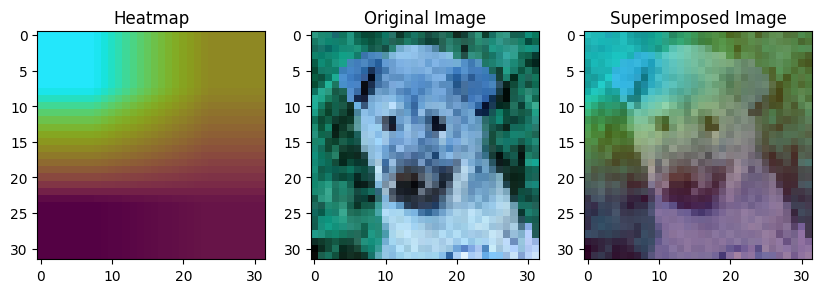

In [ ]:
import matplotlib.pyplot as plt

# Get the class label corresponding to the highest predicted probability
predicted_label = np.argmax(preds[0])

# Display the predicted label along with the heatmap visualization
fig, ax = plt.subplots(1, 3, figsize=(10, 5))  # Increase the figure size here

ax[0].imshow(heatmap)
ax[0].set_title('Heatmap')

ax[1].imshow(image)
ax[1].set_title('Original Image')

ax[2].imshow(output)
ax[2].set_title('Superimposed Image')

plt.show()
